## 1.0 Problem Statement

## 2.0 Executive Summary

## 3.0 Table of Contents

## 4.0 Data Dictionary and Glossary of Terms

### 4.1 Data Dictionary

| Data Name | Data Type | Description |  
|---|---|---|  
| metascore | integer | The aggregate professional review score on Metacritic. |  
| name | object | The title of the given game. |  
| console | object | The platform the game is designed for (this value is always PC). |  
| userscore | float | The aggregate review score of semi-professional and normal players on Metacritic. |  
| release_date | datetime | The release date of the given game. |  
| review_percent_score | float | The second of two scoring metrics on Steam's back end. |  
| hours_played | float | The average time played by users. This value is 0 if the game wasn't included in the Hours Played dataset, else it is the average of all listed hours played for that title. |  
| meta_meta | float | The metascore and userscore multiplied together. This value was added to create additional weight to these metrics and improve model prediction accuracy. |  
| played_dummy | integer | A value indicating if a playtime was available for the given game. Created to add additional weight to the hours_played column, owing to its low correlation. |

### 4.2 Glossary of Terms

**Steam:** Steam is the market-leading distribution platform for PC video games, and is owned by game devloper and publisher Valve. In 2013, it had an estimated 75% market share for the PC games market, the platform generated $4.3 billion in revenue, around 18% of all PC game sales for the year.  
  
**Metacritic:** Metacritic is one of the world's largest review aggregators for pop culture content. It aggregates both professional reviewers and its own community reviews to assign games numerical values between 0-100 indicating the level of critical response to the game.  
  
**Steam Percent Reviews:** Steam has its own review service built into the platform. Steam stratifies games by 10-point windows on a scale of 0-100, with higher scores being better. Steam does not share the numerical score of a game in its forward-facing UI, only the tier the game has fallen into. The review percent score is a pure ratio of positive to negative reviews. There is a second metric that we gathered, but are not using, that uses a more complex alogrithm. I thought I had found this algorithm, but it was instead a user on the developer forum's alogrithm used to create a third scoring metric on another website.

## 5.0 Import and Clean Steam User Behavior Dataset

### 5.1 Import Block

In [91]:
import pandas as pd 
import numpy as np 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoLars, BayesianRidge, LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial'],'size':'14'}) #Credit to Dr. John Abel for sharing his presentation rc parameters

RANDOM_STATE = len("Cousin Nico, let's go bowling!") #Another time, Roman

### 5.2 Import Steam Behavior Data

The below dataset was taken from Kaggle.com, and represents steam user behaviors for 199,999 random users. The pertinent information for us in this dataset is the game title, and the user's playtime value. We'll be creating an average value of "playtime" per title, as there may be correlation between how long users play a game and how much they enjoy it. After all, it is unlikely that users are hate-playing games, though this stat could have other issues as a bad patch to a game after a user has spent hundreds of hours playing would result in a negative review.  
  
An important counterpoint to the logic behind large playtime meaning positive reviews came from the author's informal study of Steam users. A large part of the below feature interpretation happened thanks to an informal study I conducted of 20 Steam users to be used in conjunction with the Steam User Behavior dataset. 

In [160]:
steam_df = pd.read_csv(r'../datasets/steam-200k.csv')

In [161]:
steam_df

151603712  The Elder Scrolls V Skyrim  purchase    1.0  0
0       151603712  The Elder Scrolls V Skyrim      play  273.0  0
1       151603712                   Fallout 4  purchase    1.0  0
2       151603712                   Fallout 4      play   87.0  0
3       151603712                       Spore  purchase    1.0  0
4       151603712                       Spore      play   14.9  0
...           ...                         ...       ...    ... ..
199994  128470551                 Titan Souls      play    1.5  0
199995  128470551  Grand Theft Auto Vice City  purchase    1.0  0
199996  128470551  Grand Theft Auto Vice City      play    1.5  0
199997  128470551                        RUSH  purchase    1.0  0
199998  128470551                        RUSH      play    1.4  0

[199999 rows x 5 columns]

In [162]:
steam_df.drop(columns = ['0'], inplace=True)
steam_df.columns = ['user_id', 'game_title','behavior','hours_played']
purchases = steam_df[steam_df['behavior'] != 'play'].index
steam_df.drop(purchases, inplace = True)
steam_df.drop('behavior', axis = 1, inplace = True)
steam_df.sort_values(['game_title'],ascending = True, inplace = True)

In [163]:
avg_df = steam_df.groupby('game_title', as_index = False)['hours_played'].mean()
avg_df

game_title  hours_played
0                                           007 Legends      0.700000
1                                             0RBITALIS      0.400000
2     1... 2... 3... KICK IT! (Drop That Beat Like a...      4.000000
3                                       10 Second Ninja      2.950000
4                                            10,000,000      3.600000
...                                                 ...           ...
3595                                         rymdkapsel      1.100000
3596                                       sZone-Online      0.977586
3597                          the static speaks my name      0.250000
3598                                          theHunter      2.493548
3599                                   theHunter Primal     21.475000

[3600 rows x 2 columns]

This dataset was pared down significantly from the initial 199,999 rows of data. The first cut of removing "purchased" items took a whole 130,000 rows off. The second cut, consolidating all the titles together on their mean data, brought it down to just a list of 3,600 games. This potentially promising dataset may no longer be relevant, depending on size of subsequent data and title overlap.

## 6.0 Import and Clean Metacritic Dataset

The below dataset also comes from Kaggle.com. It consists of 10,451 rows of data corresponding to titles reviewed on the Metacritic website between the years 2000 and 2018. Each row corresponds to a game on a platform, so there may be 3 rows for the same game, one for each platform. We only care about the PC games, so will be filtering out every value in the console column that isn't 'PC'.  
  
This dataset will form the core of our data, as games that are listed here but aren't listed or reviewed on Steam will form our training set.

In [164]:
meta_df = pd.read_csv(r'../datasets/result.csv')
meta_df

metascore                           name console userscore  \
0             97             Grand Theft Auto V     PS3       8.3   
1             97             Grand Theft Auto V    X360       8.3   
2             95                 The Last of Us     PS3       9.2   
3             94              BioShock Infinite     PS3       8.5   
4             94              BioShock Infinite      PC       8.6   
...          ...                            ...     ...       ...   
15642         38  Touhou Kobuto V: Burst Battle  Switch       4.6   
15643         38                        Randall     PS4       2.1   
15644         36             Tokyo Tattoo Girls    VITA       5.4   
15645         26                      Road Rage     PS4       2.5   
15646         17         Vroom in the Night Sky  Switch       3.1   

               date  
0      Sep 17, 2013  
1      Sep 17, 2013  
2      Jun 14, 2013  
3      Mar 26, 2013  
4      Mar 25, 2013  
...             ...  
15642  Oct 10, 2017  
15643   Jun 6, 2017  
15644  Nov 14, 2017  
15645  Nov 14, 2017  
15646   Apr 5, 2017  

[15647 rows x 5 columns]

In [165]:
meta_df.sort_values(['name'],ascending = True, inplace = True)
console_games = meta_df[meta_df['console'] != 'PC'].index
meta_df.drop(console_games, inplace = True)
string_scores = meta_df[meta_df['userscore'] == 'tbd'].index
meta_df.drop(string_scores, inplace = True)
meta_df = meta_df.reset_index()
meta_df.drop('index', axis = 1, inplace = True)
meta_df['date'] = pd.to_datetime(meta_df['date'])
meta_df

metascore                         name console userscore       date
0            69      .hack//G.U. Last Recode      PC       6.5 2017-11-03
1            59               007: NightFire      PC         6 2002-11-28
2            70       007: Quantum of Solace      PC       6.1 2008-11-04
3            73                    0RBITALIS      PC       7.3 2015-05-28
4            72              10 Second Ninja      PC       7.4 2014-03-05
...         ...                          ...     ...       ...        ...
3785         62          continue?9876543210      PC       6.3 2014-01-03
3786         59                   inMomentum      PC       5.2 2011-10-31
3787         66                  kill.switch      PC       7.4 2004-03-30
3788         69                       nail'd      PC       7.7 2010-11-30
3789         64  theHunter: Call of the Wild      PC       7.5 2017-02-16

[3790 rows x 5 columns]

After all cleaning, our dataset of 10,000 games has been brought down to just under 4,000 titles, a respectable size for our dataset. We will need to fill in values for the Steam userscore on lines where the game is listed on Steam, and that will give us ready training (lines with Steam scores) and testing (lines without) sets.

## 7.0 Import and Combine All Data to Final Dataframe

The below dataset was collected by exporting the Metacritic dataset generated above as a CSV and manually imputing review_score, review_percent_score, and app_id into the .csv file before importing it back in. Despite communication with the developers of SteamSpy and SteamDB, the two most reliable data aggregators, regarding scraping for data or downloading their gathered data, neither site's servers had the capacity to handle a web-scraper, and didn't store review data locally.  
  
While a Steam Python API exists, the documentation is not very good and, like all other scrape methods I'd use, reliant on the app_id integer, a number that cannot be gathered without scraping the whole Steam library, as Steam doesn't have a way to "reverse search" a title against its app_id in the API. The only option was therefore to impute data by hand. A humongous thanks to SteamDB's developers, who helped me verify the data after the imputing process.  
  
Note that older titles on Steam are often rereleased under new names or editions, often with all the content bundled and any release bugs patched. If I could not readily verify by tracing the release dates of the packages that the listed game was the same as the one reviewed on Metacritic, I skipped over it to avoid using incorrect data. I estimate that this method of data curation cost me approximately 200 rows of data, or 5% of my overall data.

### 7.1 Re-import Score Data

In [166]:
scores_df = pd.read_csv(r'../datasets/df_for_data.csv')
scores_df

metascore                         name console  userscore release_date  \
0            69      .hack//G.U. Last Recode      PC        6.5   2017-11-03   
1            59               007: NightFire      PC        6.0   2002-11-28   
2            70       007: Quantum of Solace      PC        6.1   2008-11-04   
3            73                    0RBITALIS      PC        7.3   2015-05-28   
4            72              10 Second Ninja      PC        7.4   2014-03-05   
...         ...                          ...     ...        ...          ...   
3785         62          continue?9876543210      PC        6.3   2014-01-03   
3786         59                   inMomentum      PC        5.2   2011-10-31   
3787         66                  kill.switch      PC        7.4   2004-03-30   
3788         69                       nail'd      PC        7.7   2010-11-30   
3789         64  theHunter: Call of the Wild      PC        7.5   2017-02-16   

        app_id  review_score  review_percent_score  
0     525480.0           8.0                  87.0  
1          NaN           NaN                   NaN  
2          NaN           NaN                   NaN  
3     278440.0           6.0                  71.0  
4     271670.0           8.0                  85.0  
...        ...           ...                   ...  
3785  263340.0           5.0                  56.0  
3786  110400.0           6.0                  75.0  
3787       NaN           NaN                   NaN  
3788   40380.0           6.0                  79.0  
3789  518790.0           8.0                  82.0  

[3790 rows x 8 columns]

### 7.2 Join Behavior and Score Datasets

In [ ]:
games_df = pd.merge(left=scores_df, right=avg_df, how='left', left_on='name', right_on='game_title')
games_df

In [168]:
games_df.drop(['game_title', 'app_id', 'review_score'], axis=1, inplace=True)
games_df['meta_meta'] = games_df['metascore']*games_df['userscore']
games_df['hours_played'].fillna(0, inplace = True)
games_df['played_dummy'] = games_df['hours_played'].astype(bool).astype(int)
games_df

metascore                         name console  userscore release_date  \
0            69      .hack//G.U. Last Recode      PC        6.5   2017-11-03   
1            59               007: NightFire      PC        6.0   2002-11-28   
2            70       007: Quantum of Solace      PC        6.1   2008-11-04   
3            73                    0RBITALIS      PC        7.3   2015-05-28   
4            72              10 Second Ninja      PC        7.4   2014-03-05   
...         ...                          ...     ...        ...          ...   
3785         62          continue?9876543210      PC        6.3   2014-01-03   
3786         59                   inMomentum      PC        5.2   2011-10-31   
3787         66                  kill.switch      PC        7.4   2004-03-30   
3788         69                       nail'd      PC        7.7   2010-11-30   
3789         64  theHunter: Call of the Wild      PC        7.5   2017-02-16   

      review_percent_score  hours_played  meta_meta  played_dummy  
0                     87.0          0.00      448.5             0  
1                      NaN          0.00      354.0             0  
2                      NaN          0.00      427.0             0  
3                     71.0          0.40      532.9             1  
4                     85.0          2.95      532.8             1  
...                    ...           ...        ...           ...  
3785                  56.0          0.00      390.6             0  
3786                  75.0          0.25      306.8             1  
3787                   NaN          0.00      488.4             0  
3788                  79.0          0.00      531.3             0  
3789                  82.0          0.00      480.0             0  

[3790 rows x 9 columns]

## 8.0 Generate Training and Holdout Datasets

As I was not able to find score data for all 3,790 games, I found myself in the enviable position that I had essentially pre-built training and holdout testing datasets.

In [169]:
train = games_df[games_df['review_percent_score'] >= 1] #1 is the lowest review score we found, and I do not want to impute placeholders for NaNs
train

metascore                           name console  userscore  \
0            69        .hack//G.U. Last Recode      PC        6.5   
3            73                      0RBITALIS      PC        7.3   
4            72                10 Second Ninja      PC        7.4   
7            58                 1954: Alcatraz      PC        6.3   
8            80  1979 Revolution: Black Friday      PC        7.7   
...         ...                            ...     ...        ...   
3784         79  Zwei: The Ilvard Insurrection      PC        8.2   
3785         62            continue?9876543210      PC        6.3   
3786         59                     inMomentum      PC        5.2   
3788         69                         nail'd      PC        7.7   
3789         64    theHunter: Call of the Wild      PC        7.5   

     release_date  review_percent_score  hours_played  meta_meta  played_dummy  
0      2017-11-03                  87.0          0.00      448.5             0  
3      2015-05-28                  71.0          0.40      532.9             1  
4      2014-03-05                  85.0          2.95      532.8             1  
7      2014-03-11                  73.0          0.00      365.4             0  
8      2016-04-05                  76.0          0.00      616.0             0  
...           ...                   ...           ...        ...           ...  
3784   2017-10-31                  97.0          0.00      647.8             0  
3785   2014-01-03                  56.0          0.00      390.6             0  
3786   2011-10-31                  75.0          0.25      306.8             1  
3788   2010-11-30                  79.0          0.00      531.3             0  
3789   2017-02-16                  82.0          0.00      480.0             0  

[2304 rows x 9 columns]

In [170]:
test = games_df[games_df['review_percent_score'].isnull()]
test

metascore                              name console  userscore  \
1            59                    007: NightFire      PC        6.0   
2            70            007: Quantum of Solace      PC        6.1   
5            74         1503 A.D. - The New World      PC        7.6   
6            79                         1701 A.D.      PC        8.2   
9            69                            1nsane      PC        7.6   
...         ...                               ...     ...        ...   
3779         68                   Zoo Tycoon 2001      PC        7.7   
3780         64  Zoo Tycoon 2: Endangered Species      PC        7.8   
3781         67         Zoo Tycoon: Dinosaur Digs      PC        7.1   
3782         71          Zoo Tycoon: Marine Mania      PC        7.4   
3787         66                       kill.switch      PC        7.4   

     release_date  review_percent_score  hours_played  meta_meta  played_dummy  
1      2002-11-28                   NaN           0.0      354.0             0  
2      2008-11-04                   NaN           0.0      427.0             0  
5      2003-03-23                   NaN           0.0      562.4             0  
6      2006-11-06                   NaN           0.0      647.8             0  
9      2001-02-05                   NaN           0.0      524.4             0  
...           ...                   ...           ...        ...           ...  
3779   2001-10-17                   NaN           0.0      523.6             0  
3780   2005-10-19                   NaN           0.0      499.2             0  
3781   2002-05-19                   NaN           0.0      475.7             0  
3782   2002-10-21                   NaN           0.0      525.4             0  
3787   2004-03-30                   NaN           0.0      488.4             0  

[1486 rows x 9 columns]

This is a very aggressive training vs. holdout split. There is just over a 60:40 split of training to testing data. Unfortunately, a number of titles listed in the Metacritic dataset were either never distributed by Steam, or were removed when major publishing companies like Electronic Arts and Activiation-Blizzard released their own distribution platforms and pulled the majority of their content from Steam.  
  
More concerning is that I actually don't have a lot of features available going into testing. I've engineered on three more features to try to give more weight to things, but to use a colloquialism, there isn't a lot of blood left in this stone. I've already done what we can to boost the impact of the metascore and userscore features by creating the meta_meta column, and given that we had a tremendous amount of NaN values in 

## 9.0 EDA

### 9.1 Study of Maximum and Minimum Titles

In [171]:
top_25 = train.nlargest(25,'review_percent_score')
bot_10 = train.nsmallest(10,'review_percent_score')
big_90 = train[train['review_percent_score'] >= 90]
big_80 = train[train['review_percent_score'] >= 80]

In [172]:
big_90.shape

(564, 9)

In [173]:
big_80.shape

(1286, 9)

Let's get this out of the way now, because it speaks volumes about how the Steam Review, and review systems in general, work. A 90 under most circumstances is considered fantastic, but over 20% of our data is reviewed as 90 or greater. Almost 50% is 80 or greater. High reviews come quick on Steam, because of one very important change Steam implemented on their front end.  
  
Steam only allows for binary reviews. Users either felt positively about the game, or felt negatively. There is no neutral, though users can use a text box to elaborate on how they feel. However, the review percent score is a ratio of the Postive and Negative reviews, there is no more numeric, or even scale system available. According to some developer forum members, it's really unclear how older games had their scores migrated over to the new system, so those games may be skewed.

In [174]:
top_25

metascore                                       name console  userscore  \
261          91                        Batman: Arkham City      PC        8.7   
870          80           Dishonored: The Knife of Dunwall      PC        8.3   
29           79                              A Hat in Time      PC        8.4   
869          80           Dishonored: The Brigmore Witches      PC        8.7   
1321         85                     Giants: Citizen Kabuto      PC        8.8   
2285         90                                     Portal      PC        9.2   
2286         95                                   Portal 2      PC        9.0   
3046         86              The Binding of Isaac: Rebirth      PC        8.4   
3325         93                   The Witcher 3: Wild Hunt      PC        9.3   
3326         92  The Witcher 3: Wild Hunt - Blood and Wine      PC        9.2   
3758         79                                    Youropa      PC        6.6   
287          85                        BattleBlock Theater      PC        7.9   
438          83                                   Broforce      PC        8.0   
517          88                                    Celeste      PC        7.2   
648          88                             Counter-Strike      PC        9.2   
755          86             Day of the Tentacle Remastered      PC        7.9   
791          78                                DeathSmiles      PC        7.0   
866          91                                 Dishonored      PC        8.4   
1028         76                              Escape Goat 2      PC        7.5   
1035         79                     Euro Truck Simulator 2      PC        8.7   
1188         81                           Finding Paradise      PC        8.3   
1344         84                                    Gorogoa      PC        8.4   
1364         75                              Gravity Ghost      PC        7.7   
1395         83                                   Gunpoint      PC        8.4   
1405         96                                Half-Life 2      PC        9.1   

     release_date  review_percent_score  hours_played  meta_meta  played_dummy  
261    2011-11-21                  99.0      0.000000      791.7             0  
870    2013-04-16                  99.0      0.000000      664.0             0  
29     2017-10-05                  98.0      0.000000      663.6             0  
869    2013-08-13                  98.0      0.000000      696.0             0  
1321   2000-12-06                  98.0      0.000000      748.0             0  
2285   2007-10-10                  98.0      5.474341      828.0             1  
2286   2011-04-18                  98.0     20.126049      855.0             1  
3046   2014-11-04                  98.0      0.000000      722.4             0  
3325   2015-05-18                  98.0      0.000000      864.9             0  
3326   2016-05-30                  98.0      0.000000      846.4             0  
3758   2018-06-27                  98.0      0.000000      521.4             0  
287    2014-05-15                  97.0      5.902830      671.5             1  
438    2014-04-07                  97.0     26.476923      664.0             1  
517    2018-01-25                  97.0      0.000000      633.6             0  
648    2000-11-08                  97.0    236.375176      809.6             1  
755    2016-03-21                  97.0      0.000000      679.4             0  
791    2016-03-10                  97.0      0.000000      546.0             0  
866    2012-10-08                  97.0     19.601379      764.4             1  
1028   2014-03-24                  97.0      0.000000      570.0             0  
1035   2013-01-16                  97.0     42.262573      687.3             1  
1188   2017-12-14                  97.0      0.000000      672.3             0  
1344   2017-12-14                  97.0      0.000000      705.6             0  
1364   2015-01-26                  9

The Top 25 games is a really curious mix of games. There are some really obvious entities in here, like _The Witcher 3_, _Portal 2_ (side fact: the author's first date with his wife was playing this game), _Arkham City_, and _Euro Truck Simulator 2_, some of the most beloved games for PC. However, there are some games in here that reflect the oddity that is the review system.  
  
_Giants: Citizen Kabuto_, a quirky action game from 2000, has only 58 reviews in total, compared to the hundreds of thousands for _Portal 2_, composed primarily of users who loved the game when it first came out and were rewilling to re-buy it and review it.

In [175]:
bot_10

metascore                                    name console  userscore  \
1198         23          FlatOut 3: Chaos & Destruction      PC        3.3   
602          64  Command & Conquer 4: Tiberian Twilight      PC        2.1   
119          19         Alone in the Dark: Illumination      PC        1.2   
1383         56               Guardians of Middle-Earth      PC        5.9   
3496         50                                   Tryst      PC        6.4   
1036         69                     Eurofighter Typhoon      PC        7.2   
1307         53                             Gemini Wars      PC        6.5   
2498         43              RollerCoaster Tycoon World      PC        2.1   
321          46                          BeachHead 2000      PC        7.0   
2538         57                                Sacred 3      PC        1.5   

     release_date  review_percent_score  hours_played  meta_meta  played_dummy  
1198   2011-12-13                  13.0      0.000000       75.9             0  
602    2010-03-16                  18.0      0.000000      134.4             0  
119    2015-06-11                  20.0      0.000000       22.8             0  
1383   2013-08-29                  22.0      0.000000      330.4             0  
3496   2012-09-14                  22.0     21.000000      320.0             1  
1036   2001-07-30                  23.0      0.300000      496.8             1  
1307   2012-06-08                  23.0      1.900000      344.5             1  
2498   2016-11-16                  24.0      0.000000       90.3             0  
321    2000-06-14                  25.0      0.000000      322.0             0  
2538   2014-07-31                  25.0     26.083333       85.5             1

### 9.2 Review of Data Distribution and Relationships

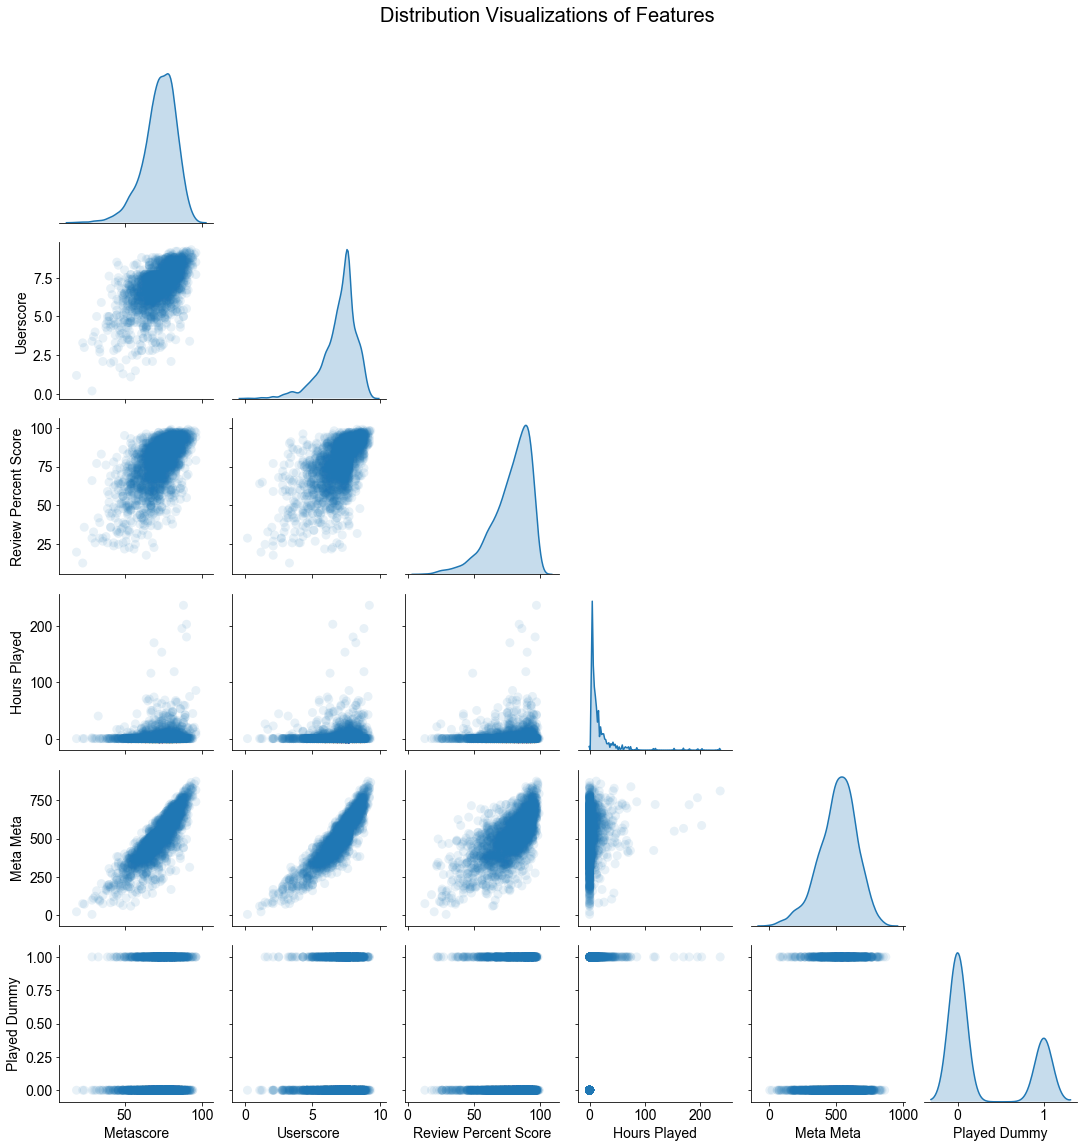

In [207]:
pairplotdf = train.copy()
pairplotdf.columns = pairplotdf.columns.str.replace("_"," ").str.title()
pp = sns.pairplot(pairplotdf, corner=True, diag_kind='kde', plot_kws = {'alpha': 0.1, 's': 80, 'edgecolor': ''})
pp.fig.suptitle('Distribution Visualizations of Features', y=1.05, fontsize = 20);
pp.savefig('pairplot.png')

There is a general linear trend to our data. 'Meta meta' definitely helped reduce the variance between userscore and metascore that was previously prevalent. Time played doesn't really have a strong correlation to anything, as was expected, but any relationship is a good relationship given that we are feature-light in this model. Also of note is that we are very right-skewed in all our data, which makes sense based on the cloud-density of each our features. It's pretty rare for a game to be horribly received, so there will be  heavier weight towards positive reviews.

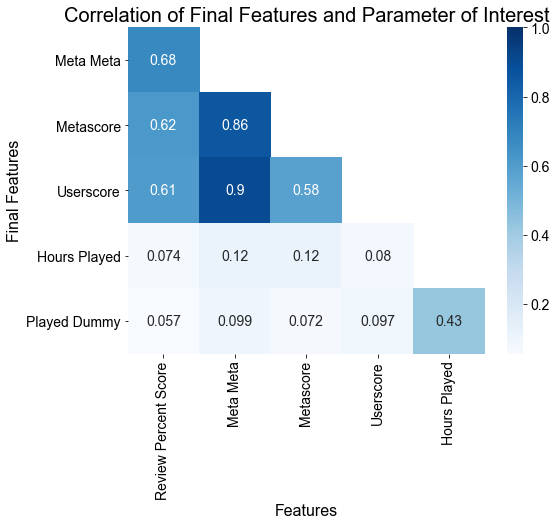

In [177]:
#The below code was modified from the Week 4.2 lesson on Visualiziations by Mahdi Shadkam-Farrokhi.
#Data prep block
corr = train.corr()
col_order = corr.sort_values('review_percent_score', ascending=False).index
ordered_df = train[col_order]
ordered_df.columns = ordered_df.columns.str.replace("_"," ").str.title()

#Plotting block
fig = plt.figure(figsize=(8,6))
mask = np.triu(np.ones_like(corr))
ax = sns.heatmap(ordered_df.corr(), annot=True, mask = mask, cmap = 'Blues')
ax.set_title('Correlation of Final Features and Parameter of Interest', fontsize=20)
ax.set_xlabel('Features', fontsize = 16)
ax.set_ylabel('Final Features', fontsize = 16)
y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
ax.set_ylim(top=y_max+1)
ax.set_xlim(right=x_max-1);
plt.savefig('heatmap.png')

At our best, the Meta Meta feature is the most highly correlated to our target feature, though at .68, that's not as high as it really could be. Obviously our highest correlation is between Meta Meta and its components, Userscore and Metascore. On the opposite end, there is almost zero correlation between any features and Hours Played and Played Dummy, which makes sense that given our data shapes, playtime doesn't really factor into any of our other features.

## 10.0 Modeling

### 10.1 Defining X & y

In [178]:
features = ['metascore','userscore','meta_meta', 'hours_played', 'played_dummy']

X = train[features]
y = train['review_percent_score']

In [179]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = RANDOM_STATE)

### 10.2 Baseline Model

In [221]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
bl_preds = dummy.predict(X_test)

In [181]:
def get_scores(model, preds_name):
    print('Training Score:'+str(model.score(X_train,y_train)))  
    print('Testing Score:'+str(model.score(X_test,y_test)))  
    # print('Cross Val Score:'+str(cross_val_score(model,X,y).mean()))
    print('Test RMSE:'+str(np.sqrt(mean_squared_error(y_test, preds_name))))

In [222]:
get_scores(dummy, bl_preds)

Training Score:0.0
Testing Score:-7.5976730919968816e-06
Test RMSE:14.696558582421924


This is, hopefully, not a difficult bar to beat. After all, you need only get on the first step to get out of the basement, and these scores are predictably bad. Our RMSE is just shy of 15 points, meaning that for a given game, the best this model can do is predict a 30-point spread, which is an unacceptable level of variance.

### 10.3 Standard Linear Regression

There was a "blob" effect in the earlier data distributions we saw, but also visible linear trend. Due that trend, we are starting with a basic Linear Regression model.

In [265]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

In [184]:
get_scores(lr, lr_preds)

Training Score:0.46919066146042193
Testing Score:0.492150842281429
Test RMSE:10.473247544462605


In [270]:
def dist_hist(actuals, preds,title):
    plt.figure(figsize=(15,8))
    plt.hist(x = [actuals,preds],
            bins = 100,
            color = ['#05a4ed', '#fa8900'],
            label = ['Actual Values', 'Predictions'])
    plt.legend(fontsize=16)
    plt.title(f'{title}', fontsize=20)
    plt.xlabel('Score Value', fontsize=16)
    plt.ylabel('Count', fontsize=16);

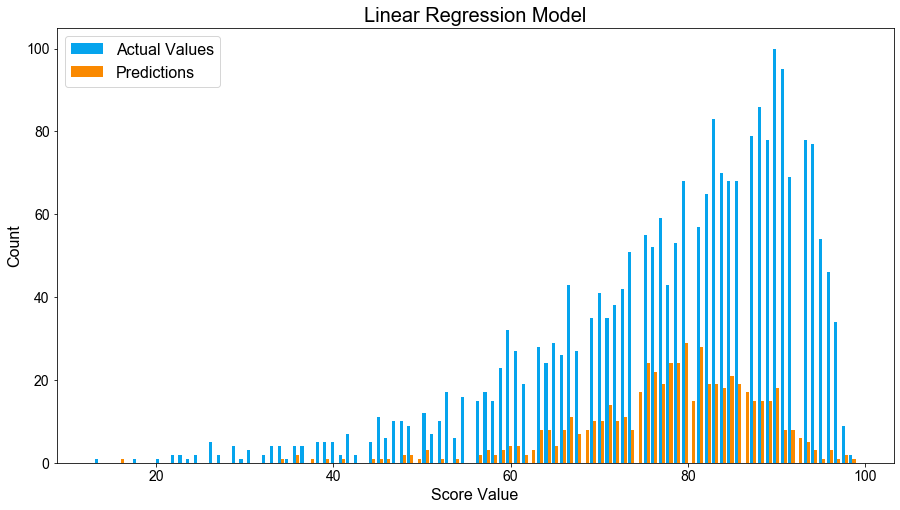

In [271]:
dist_hist(train['review_percent_score'], lr_preds, 'Linear Regression Model')

The Linear Regression model is actually skewed slightly more left than our data, which unfortunately is already an indicator that we're not going to be predicting the higher end of our scores correctly. You can see that the peak of our Linear regression model is around the 80s, while the peak of our actual data is in the 90s.
  
This is a marked improvement over our baseline model on scores, but the low scores are showing a trend of underfitting. This is expected, given that we don't have a lot to give our model in the way of features in the first place, and there was already not a high correlation between those features. Regularization won't do much to help us, as we're trying to fit a line to blob and our model isn't overfit. We're going to move on to boosting, which will help us make the most of our small number of features, and hopefully improve performance.

### 10.4 AdaBoost

In [185]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())
ada_params = {
    'n_estimators': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'base_estimator__max_depth': [1,1.5,2,2.5,3,3.5,4,4.5,5],
    'learning_rate': [.05,.07,.075,.08,.085,.09,.095,.1,.105,.2,.205]
}
gs_ada = GridSearchCV(ada, param_grid=ada_params, cv=5)
gs_ada.fit(X_train, y_train)
print(gs_ada.best_score_)
ada_preds = gs_ada.predict(X_test)

0.45209787470885915


In [186]:
gs_ada.best_params_

{'base_estimator__max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 11}

In [187]:
get_scores(gs_ada, ada_preds)

Training Score:0.5064015890493754
Testing Score:0.47355995258825556
Test RMSE:10.663222224585216


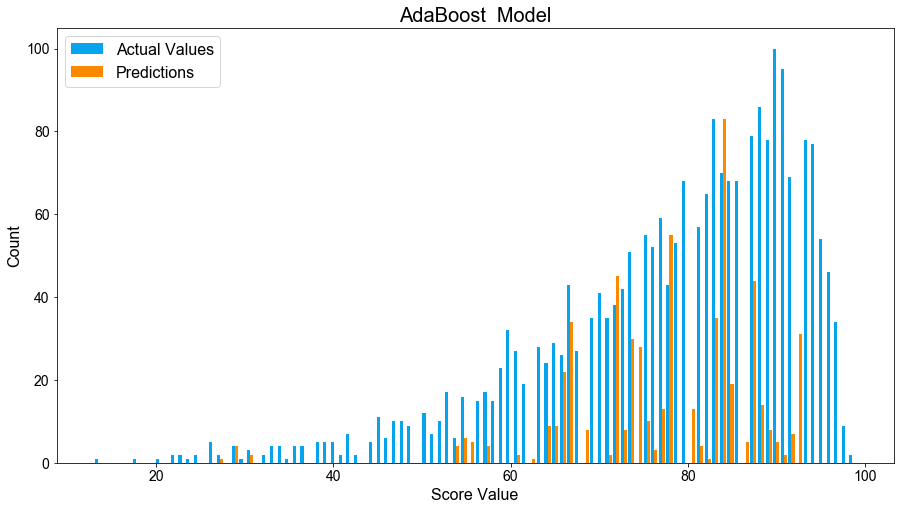

In [272]:
dist_hist(train['review_percent_score'], ada_preds, 'AdaBoost  Model')

Unlike the Linear Regression, the predictions are all over the map on the AdaBoost. It is vaguely the same shape, but it is latching on to certain spikes and missing the overall data trend.

AdaBoost actually saw a drop in testing score and RMSE compared to Linear Regression. With a testing score of 46.65 and an RMSE of 10.83, compared to 48.68 and 10.63, it's just slightly worse than Linear Regression. We are seeing it fit better to the training data, which is good (we're starting to see a little more of that overfitting). More importantly, while the RMSE is close to the Linear Regression model, the prediction distribution looks nothing like the actual data. During initial testing of these two forms of boosting, I had more success with GradientBoost in terms of scoring.

### 10.5 GradientBoost

In [204]:
grad = GradientBoostingRegressor()
grad_params = {
    'max_depth': [2.1,2.3,2.5,2.7],
    'n_estimators': [50,52,54,56,58,60],
    'learning_rate': [.111,.112,.113,.114,.115]
}
gs_grad = GridSearchCV(grad, param_grid=grad_params, cv=5)
gs_grad.fit(X_train, y_train)
print(gs_grad.best_score_)
grad_preds = gs_grad.predict(X_test)

0.4600595048414453


In [205]:
gs_grad.best_params_

{'learning_rate': 0.114, 'max_depth': 2.7, 'n_estimators': 54}

In [206]:
get_scores(gs_grad, grad_preds)

Training Score:0.5227756234471216
Testing Score:0.4850125002061215
Test RMSE:10.546596825341329


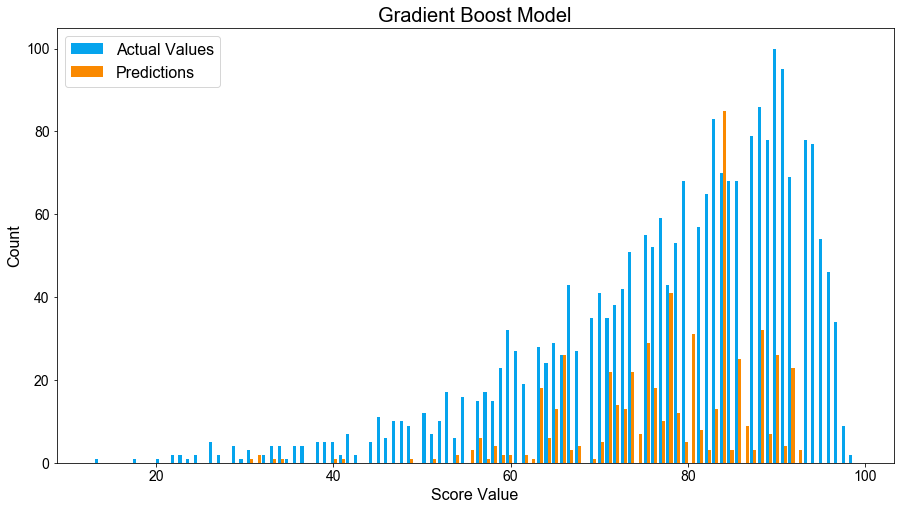

In [273]:
dist_hist(train['review_percent_score'], grad_preds, 'Gradient Boost Model')

Like the AdaBoost model, the GradientBoost model is matching the general shape, but missing a lot of predictions, or latching onto very specific spikes while completely missing others.

I spent a considerable amount of time tweaking hyperparameters on GradientBoost, which was the more promising of the two boosting models, but we're still 1.5 points above the basic Linear Regression model. We're going to move on to a RandomForest model, but if that still can't get me ahead, we'll go back and tweak the Linear Regression parameters and try to tune that.

### 10.6 Random Forest

In [192]:
rf = RandomForestRegressor(n_estimators=100)
rf_params = {
    'n_estimators': [50, 70, 75, 80, 100, 150, 200],
    'max_depth': [2.5, 3, 3.25, 3.5, 3.75, 4],
}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
rf_preds = gs_rf.predict(X_test)
gs_rf.best_params_

0.4502903344949914


{'max_depth': 4, 'n_estimators': 150}

In [193]:
get_scores(gs_rf, rf_preds)

Training Score:0.5161805370632251
Testing Score:0.4826760342066402
Test RMSE:10.570494374884113


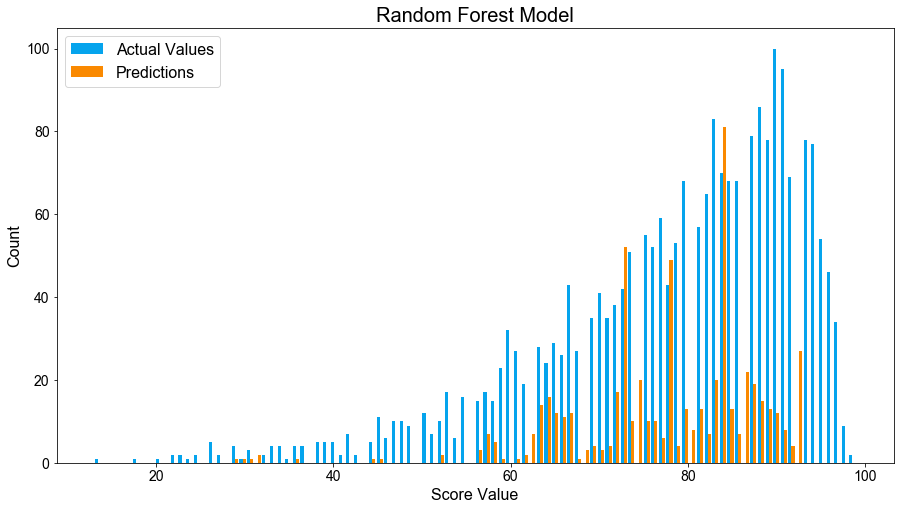

In [274]:
dist_hist(train['review_percent_score'], rf_preds, 'Random Forest Model')

This is doing even worse than the Gradient Boost most times, and given that it is random, it's practically impossible to tune this model to try for consistent results. Re-running the cell results in a new best_params dictionary each time.
  
Given my experience with the above, I have opted to not continue to the Extra Trees model, or frankly any other models, and just return to the Linear Regression, which to date, despite its basic nature, is giving me the best score.

## 11.0 Model Evaluation

| Data Name  | Data Type  | Description  |
|---|---|---|
| title  |  object | The title of a given post  |
| selftext  |  object | The body of the post  |
| subreddit  |  object | The subreddit the post was in |
| num_comments  | integer  | The number of comments on the post  |
| score  | integer  |  The sum of the upvotes (positive ingegers) and downvotes (negative integers) on the post (higher is better) |

## 12.0 Model Selection and Results

Based on the below RMSEs, it is very clear that the best-performing model in this case is also the most elementary. Our simple Linear Regression, with no boosting, regularizing, or hyperparameter tuning of any kind, out-performed many other more advanced models.

### 12.1 Prepping the Holdout Set and Getting Predictions

In [194]:
X = test[features]

In [195]:
lr_preds = lr.predict(X)
lr_preds

array([66.17030618, 73.10763389, 81.68089069, ..., 75.65083694,
       79.17754109, 76.3862788 ])

### 12.2 Inserting Predictions Back into Dataframe

In [196]:
results = test
lr_preds.round()
results['review_percent_score'] = lr_preds

In [197]:
results

metascore                              name console  userscore  \
1            59                    007: NightFire      PC        6.0   
2            70            007: Quantum of Solace      PC        6.1   
5            74         1503 A.D. - The New World      PC        7.6   
6            79                         1701 A.D.      PC        8.2   
9            69                            1nsane      PC        7.6   
...         ...                               ...     ...        ...   
3779         68                   Zoo Tycoon 2001      PC        7.7   
3780         64  Zoo Tycoon 2: Endangered Species      PC        7.8   
3781         67         Zoo Tycoon: Dinosaur Digs      PC        7.1   
3782         71          Zoo Tycoon: Marine Mania      PC        7.4   
3787         66                       kill.switch      PC        7.4   

     release_date  review_percent_score  hours_played  meta_meta  played_dummy  
1      2002-11-28             66.170306           0.0      354.0             0  
2      2008-11-04             73.107634           0.0      427.0             0  
5      2003-03-23             81.680891           0.0      562.4             0  
6      2006-11-06             86.861156           0.0      647.8             0  
9      2001-02-05             78.913822           0.0      524.4             0  
...           ...                   ...           ...        ...           ...  
3779   2001-10-17             78.789220           0.0      523.6             0  
3780   2005-10-19             77.023732           0.0      499.2             0  
3781   2002-05-19             75.650837           0.0      475.7             0  
3782   2002-10-21             79.177541           0.0      525.4             0  
3787   2004-03-30             76.386279           0.0      488.4             0  

[1486 rows x 9 columns]

### 12.3 Plotting Predictions against Training Values

### 12.4 Assessment of Predictions Against Real-World Results

In [198]:
results.sort_values('review_percent_score',ascending=False)

metascore                                     name console  userscore  \
3193         96                           The Orange Box      PC        9.2   
248          95         Baldur's Gate II: Shadows of Amn      PC        9.2   
3603         92             Warcraft III: Reign of Chaos      PC        9.1   
3192         91      The Operative: No One Lives Forever      PC        8.8   
1542         91                           IL-2 Sturmovik      PC        8.7   
...         ...                                      ...     ...        ...   
3021         24             Terrawars: New York Invasion      PC        2.4   
1732         20      Leisure Suit Larry: Box Office Bust      PC        2.3   
2360         26                        R.I.P.D. The Game      PC        1.5   
1570         20  Infestation: Survivor Stories The War Z      PC        1.7   
2452         16                Ride to Hell: Retribution      PC        1.2   

     release_date  review_percent_score  hours_played  meta_meta  played_dummy  
3193   2007-10-10             99.633127           0.0      883.2             0  
248    2000-09-24             99.118422           0.0      874.0             0  
3603   2002-07-03             97.203561           0.0      837.2             0  
3192   2000-11-11             95.566935           0.0      800.8             0  
1542   2001-11-18             95.193767           0.0      791.7             0  
...           ...                   ...           ...        ...           ...  
3021   2006-07-06             26.176538           0.0       57.6             0  
1732   2009-03-31             22.914722           0.0       46.0             0  
2360   2013-07-16             22.761160           0.0       39.0             0  
1570   2012-10-15             19.645081           0.0       34.0             0  
2452   2013-06-24             14.087377           0.0       19.2             0  

[1486 rows x 9 columns]

In [230]:
results[results['name'].str.contains('World of Warcraft')]

metascore                                       name console  userscore  \
3700         93                          World of Warcraft      PC        7.3   
3701         79      World of Warcraft: Battle for Azeroth      PC        3.1   
3702         90               World of Warcraft: Cataclysm      PC        5.6   
3703         88                  World of Warcraft: Legion      PC        7.3   
3704         82       World of Warcraft: Mists of Pandaria      PC        5.0   
3705         91     World of Warcraft: The Burning Crusade      PC        8.0   
3706         87     World of Warcraft: Warlords of Draenor      PC        5.9   
3707         91  World of Warcraft: Wrath of the Lich King      PC        7.6   

     release_date  review_percent_score  hours_played  meta_meta  played_dummy  
3700   2004-11-23             91.090766           0.0      678.9             0  
3701   2018-08-13             66.348985           0.0      244.9             0  
3702   2010-12-07             83.023776           0.0      504.0             0  
3703   2016-08-30             88.287407           0.0      642.4             0  
3704   2012-09-25             75.839723           0.0      410.0             0  
3705   2007-01-16             92.581595           0.0      728.0             0  
3706   2014-11-13             82.366909           0.0      513.3             0  
3707   2008-11-13             91.088925           0.0      691.6             0

In [200]:
results[results['name'].str.contains('Diablo II')]

metascore                                 name console  userscore  \
844         88                            Diablo II      PC        8.8   
845         87       Diablo II: Lord of Destruction      PC        9.0   
846         88                           Diablo III      PC        4.1   
847         87          Diablo III: Reaper of Souls      PC        6.6   
848         76  Diablo III: Rise of the Necromancer      PC        4.8   

    release_date  review_percent_score  hours_played  meta_meta  played_dummy  
844   2000-06-29             93.993789           0.0      774.4             0  
845   2001-06-27             94.235097           0.0      783.0             0  
846   2012-05-15             76.113793           0.0      360.8             0  
847   2014-03-25             85.046822           0.0      574.2             0  
848   2017-06-27             71.322910           0.0      364.8             0

In [201]:
train[train['name'].str.contains('Call of Duty')]

metascore                            name console  userscore  \
475         91                    Call of Duty      PC        8.5   
476         86                  Call of Duty 2      PC        8.4   
477         92  Call of Duty 4: Modern Warfare      PC        8.5   
479         81         Call of Duty: Black Ops      PC        5.3   
481         74      Call of Duty: Black Ops II      PC        4.3   
482         73     Call of Duty: Black Ops III      PC        3.0   
483         68            Call of Duty: Ghosts      PC        2.1   
484         73  Call of Duty: Infinite Warfare      PC        3.4   
485         86  Call of Duty: Modern Warfare 2      PC        4.3   
487         87  Call of Duty: United Offensive      PC        8.2   
488         73              Call of Duty: WWII      PC        3.3   
489         83      Call of Duty: World at War      PC        7.5   

    release_date  review_percent_score  hours_played  meta_meta  played_dummy  
475   2003-10-29                  93.0      2.966667      773.5             1  
476   2005-10-25                  91.0      5.187500      722.4             1  
477   2007-11-05                  92.0      0.000000      782.0             0  
479   2010-11-09                  89.0      0.000000      429.3             0  
481   2012-11-12                  85.0      0.000000      318.2             0  
482   2015-11-05                  69.0      0.000000      219.0             0  
483   2013-11-04                  59.0      0.000000      142.8             0  
484   2016-11-04                  46.0      0.000000      248.2             0  
485   2009-11-10                  92.0      0.000000      369.8             0  
487   2004-09-14                  86.0      0.000000      713.4             0  
488   2017-11-03                  60.0      0.000000      240.9             0  
489   2008-11-10                  93.0      0.000000      622.5             0

Before analyzing the data, we should establish a benchmark for commercial success. I am considering a game clearing 1 million units in sales to be a major success, though that is a very high bar to meet, and many studios have achieved profitability well below that threshhold. I'm focusing on that number because games that reach that value are also likely household names. 

Predictions are, it seems, pretty on point here. Our top 3 scores are a who's-who of classics. The Orange Box, while no longer distributed, was a bundle of Valve's "greatest hits," including Portal, Half-Life 2, and Team Fortress 2. It sold around 3 million units by 2008, according to Gamasutra.  
  
Likewise, Baldur's Gate sold 2 million units per Bioware, its developer's, sales figures. And of course, Warcraft III: Reign of Chaos, which also cleared 3 million in sales before being eclipsed by World of Warcraft, which per our search below has a 90.6 Review Percent Score and has grossed in excess of $9 Billion dollars between 2004 and 2017.  
  
I managed to find Ride to Hell: Retribution on SteamDB under a different name when doing this assessment. Where my model predicted a dismal 18.3, Steam's actual percent score for this game is a staggering 45. Ride to Hell presents a very interesting point as to why review percent score may not be the best metric to check a game's commercial success against.  
  
Ride to Hell is considered to be one of the worst games ever made. Ben Croshaw, a reviewer for _The Escapist_ magazine and host of Zero Punctuation, awarded it the "Lifetime Achievement Award for Total Abhorrence" and said that "releasing every box with no disc would have been less of a mistake," but also likened it to legendary movie _The Room_, which has achieved some commercial success for being so bad that it has come full circle and achieved some commercial success on the grounds it is so bad that it merits buying just to witness the badness.  
  
Similarly bucking the trend, Call of Duty: Black Ops III, with an actual mediocre review percent score of 69, grossed $550 million in sales in the first (3) days of release and sold 6.6 million copies by the end of that week, making it a staggering commercial success.

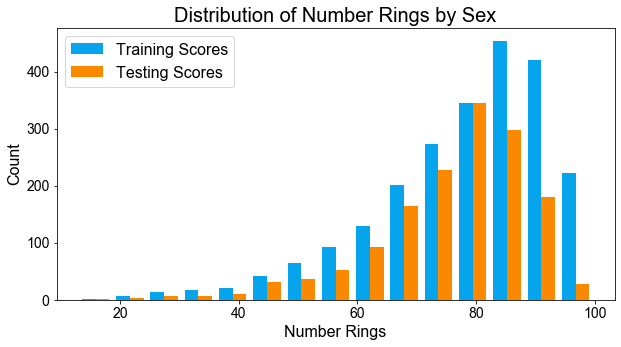

In [220]:
plt.figure(figsize=(10,5))
plt.hist(x = [train['review_percent_score'],results['review_percent_score']],
        bins = 15, 
        color = ['#05a4ed', '#fa8900'],
        label = ['Training Scores', 'Testing Scores'])
plt.legend(fontsize=16)
plt.title('Distribution of Number Rings by Sex', fontsize=20)
plt.xlabel('Number Rings', fontsize=16)
plt.ylabel('Count', fontsize=16);

## 13.0 Conclusions

First and foremost, our model was not an effective predictor of review percent score. A 21-point window, despite being markedly better than our baseline 30 points, is still a vast discrepancy. Our target was to reach a 5-point window, but given the lack of features we could find, it's unlikely that the amount of data available to the average developer or publisher just prior to the launch window will be enough to accurately predict user reaction or revenue models.  
  
More importantly though, the study of this model has highlighted some interesting trends in the review section of Steam. Professional opinion isn't always the bellweather for what the broader gaming community's opinion will be.

## 14.0 References

A tremendous thanks to SteamDB developers xPaw and Marlamin, who helped me verify to confirm my ids matched their respective titles and scores. Additionally a huge thanks to SteamSpy developer Sergey Galyonkin, who kindly offered to help me automate data collection from his system, but didn't have the capacity to do it within the Capstone window.  
  
Additionally, a huge thanks to Steam users HendrickFalcon, Pyromancer, Najas, Lokeet, Milktea9, Spragoon, Chaella, Garflow, Prevengineer, Kyathil, AtlasBurden, DrunkPak, Citizen Khaelis, Chaunsay, Overdrive9, Runman, and Hexadrine. Their participation in my study and insight about user experience, rating games, "hours played", and in Pyromancer's case, the back end of Steam's system, were invaluable in helping select features when initially data collecting.  
  
Lastly, thank you to Dr. John Abel, whose experience in plotting statistical data was invaluable when concepting visuals and playing with visual parameters for impact.  

**Outside Sources:**  
1) https://www.gamasutra.com/view/news/112269/Analysis_Valves_Lifetime_Retail_Sales_For_HalfLife_CounterStrike_Franchises.php  
2) https://en.wikipedia.org/wiki/List_of_best-selling_PC_games#cite_note-8  
3) https://en.wikipedia.org/wiki/World_of_Warcraft#:~:text=World%20of%20Warcraft%20was%20the,game%20franchises%20of%20all%20time
4) https://en.wikipedia.org/wiki/Call_of_Duty:_Black_Ops_III#Sales  
5) https://en.wikipedia.org/wiki/Steam_(service)#:~:text=The%20Steam%20platform%20is%20the,of%20global%20PC%20game%20sales

